In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix

# Question 3

> Part 'A': *Logistic Regression*

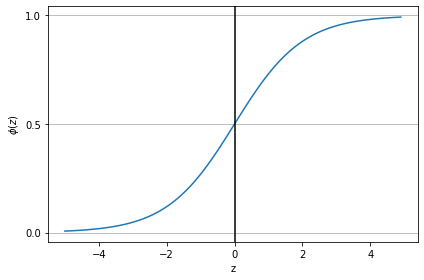

In [2]:
# Sigmoid function
#
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
# Creating sample Z points
#
z = np.arange(-5, 5, 0.1)
 
# Invoking Sigmoid function on all Z points
#
phi_z = sigmoid(z)
 
# Plotting the Sigmoid function
#
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.xlabel('z')
plt.ylabel('$\phi(z)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In [7]:
data = pd.read_csv("./Surgical.csv")
data = data.sample(frac=1)
print(data.head())

         bmi   Age  asa_status  ...  mortality_rsi  race  complication
10633  37.54  44.8           0  ...           0.00     1             0
155    25.89  58.2           0  ...          -0.55     1             0
4767   28.44  71.9           0  ...          -0.89     1             0
7037   28.98  90.0           1  ...          -2.25     1             0
8985   40.41  59.5           1  ...          -2.48     1             0

[5 rows x 25 columns]


In [8]:
# data = data.sample(frac=1, random_state=15).reset_index(drop=True)


test_num = round(len (data)*0.25)
train_num = test_num + round(len(data)*0.01)
unlab_num = train_num + round(len(data)*0.74)


# Partition the data

test = data.iloc[:test_num]
train = data.iloc[test_num:train_num]
unlab = data.iloc[train_num:unlab_num]


# Assign data to train, test, and unlabeled sets

X_train_lab = train.drop('complication', axis=1)
y_train_lab = train.complication

X_unlab = unlab.drop('complication', axis=1)

X_test = test.drop('complication', axis=1)
y_test = test.complication


# Check dimensions of data after splitting

print(f"X_train dimensions: {X_train_lab.shape}")
print(f"y_train dimensions: {y_train_lab.shape}\n")

print(f"X_test dimensions: {X_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

print(f"X_unlabeled dimensions: {X_unlab.shape}")

X_train dimensions: (146, 24)
y_train dimensions: (146,)

X_test dimensions: (3659, 24)
y_test dimensions: (3659,)

X_unlabeled dimensions: (10830, 24)


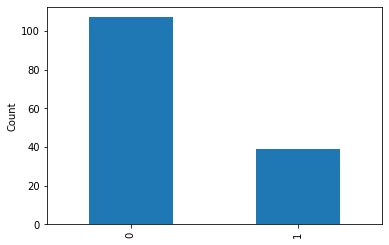

In [9]:
y_train_lab.value_counts().plot(kind='bar')
plt.xticks([0,1], ['0', '1'])
plt.ylabel('Count');

> Part 'B': *Evaluating Classifier*

In [10]:
model = LogisticRegression()
# fit model on labeled dataset
model.fit(X_train_lab, y_train_lab)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Train Accuracy: 0.821917808219178
Test Accuracy: 0.7671494943973763
Train f1 Score: 0.6176470588235294
Test f1 Score: 0.44747081712062253


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


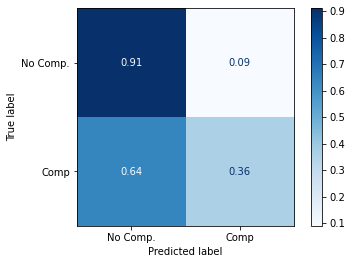

In [11]:
yhat_test = model.predict(X_test)
yhat_train = model.predict(X_train_lab)


accuracy_test = accuracy_score(y_test, yhat_test)
accuracy_train = accuracy_score(y_train_lab, yhat_train)

f1_score_test = f1_score(y_test, yhat_test)
f1_score_train = f1_score(y_train_lab, yhat_train)

confusion_matrix_test = confusion_matrix(y_test, yhat_test)
confusion_matrix_train = confusion_matrix(y_train_lab, yhat_train)

# summarize score
print(f"Train Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

print(f"Train f1 Score: {f1_score_train}")
print(f"Test f1 Score: {f1_score_test}")

plot_confusion_matrix(model, X_test, y_test, cmap='Blues', normalize='true', display_labels=['No Comp.', 'Comp'])

> Part 'C': *Self-Training*

In [12]:
#predict probs
predict_probs = model.predict_proba(X_test)
print(predict_probs)

[[0.83562904 0.16437096]
 [0.54223452 0.45776548]
 [0.83740574 0.16259426]
 ...
 [0.11722494 0.88277506]
 [0.94745207 0.05254793]
 [0.94745207 0.05254793]]


In [13]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_lab, y_train_lab)
    y_hat_train = clf.predict(X_train_lab)
    y_hat_test = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 = f1_score(y_train_lab, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlab)
    preds = clf.predict(X_unlab)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlab.index
    
    # Separate predictions with > 99% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train_lab = pd.concat([X_train_lab, X_unlab.loc[high_prob.index]], axis=0)
    y_train_lab = pd.concat([y_train_lab, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlab = X_unlab.drop(index=high_prob.index)
    print(f"{len(X_unlab)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1

Iteration 0
Train f1: 0.5846153846153846
Test f1: 0.4373368146214099
Now predicting labels for unlabeled data...
403 high-probability predictions added to training data.
10427 unlabeled instances remaining.

Iteration 1
Train f1: 0.6888888888888889
Test f1: 0.440721649484536
Now predicting labels for unlabeled data...
308 high-probability predictions added to training data.
10119 unlabeled instances remaining.

Iteration 2
Train f1: 0.7941176470588235
Test f1: 0.43472668810289383
Now predicting labels for unlabeled data...
231 high-probability predictions added to training data.
9888 unlabeled instances remaining.

Iteration 3
Train f1: 0.8613861386138614
Test f1: 0.43550446998722864
Now predicting labels for unlabeled data...
160 high-probability predictions added to training data.
9728 unlabeled instances remaining.

Iteration 4
Train f1: 0.8793103448275861
Test f1: 0.4370607028753994
Now predicting labels for unlabeled data...
131 high-probability predictions added to training data.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


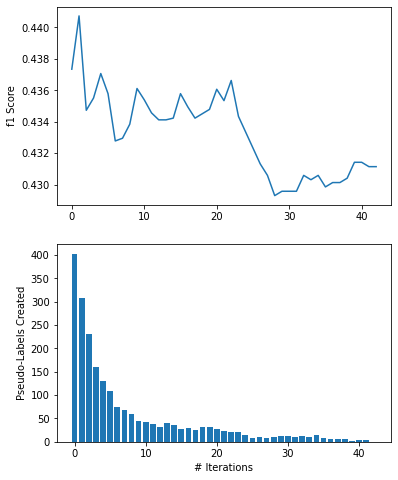

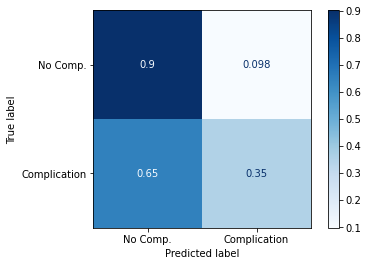

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No Comp.', 'Complication']);